In [147]:
import pandas as pd
import numpy as np

In [148]:
df = pd.read_csv('/home/rmartinez/Documents/github_projects/mexico_earthquakes/data/sismos.csv', encoding='latin1')

/home/rmartinez/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [149]:
df.describe()

,Latitud,Longitud
count,137020.000000,137020.000000
mean,17.330889,-98.130885
std,3.826909,5.422786
min,11.752000,-120.595000
25%,15.590000,-100.050000
50%,16.320000,-97.590000
75%,17.330000,-94.450000
max,33.466500,-85.546700


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137020 entries, 0 to 137019
Data columns (total 10 columns):
Fecha           137020 non-null object
Hora            137020 non-null object
Magnitud        137020 non-null object
Latitud         137020 non-null float64
Longitud        137020 non-null float64
Profundidad     137020 non-null object
Localizacion    137020 non-null object
Fecha_UTC       137020 non-null object
Hora_UTC        137020 non-null object
Estatus         137020 non-null object
dtypes: float64(2), object(8)
memory usage: 10.5+ MB


In [151]:
magnitud_df = df[df.Magnitud!='no calculable']
magnitud_df_2 = pd.DataFrame(magnitud_df['Magnitud'].astype('float64'), columns=['Magnitud'])
magnitud_mean = magnitud_df_2['Magnitud'].mean()
df.replace('no calculable', magnitud_mean, inplace=True)
df.iloc[140]
df['Magnitud']= pd.DataFrame(df['Magnitud'].astype('float64'), columns=['Magnitud'])

profundidad_df = df[df.Profundidad!='en revision']
profundidad_df_2 = pd.DataFrame(profundidad_df['Profundidad'].astype('float64'), columns=['Profundidad'])
profundidad_mean = profundidad_df_2['Profundidad'].mean()
df.replace('en revision', profundidad_mean, inplace=True)
df['Profundidad']= pd.DataFrame(df['Profundidad'].astype('float64'), columns=['Profundidad'])
df.iloc[56208]


#df.info()
#magnitud_new = pd.DataFrame(df['Magnitud'].astype('float64'), columns=['Magnitud'])
#df['Magnitud'].fillna()

Fecha                                  2012-06-29
Hora                                     11:40:01
Magnitud                                      4.2
Latitud                                   13.5565
Longitud                                 -92.1658
Profundidad                               34.8478
Localizacion    124 km al SUR de CD HIDALGO, CHIS
Fecha_UTC                              2012-06-29
Hora_UTC                                 16:40:01
Estatus                                  revisado
Name: 56208, dtype: object

In [152]:
df.corr()

,Magnitud,Latitud,Longitud,Profundidad
Magnitud,1.000000,-0.122907,0.137557,0.144579
Latitud,-0.122907,1.000000,-0.889023,-0.161381
Longitud,0.137557,-0.889023,1.000000,0.348676
Profundidad,0.144579,-0.161381,0.348676,1.000000


In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137020 entries, 0 to 137019
Data columns (total 10 columns):
Fecha           137020 non-null object
Hora            137020 non-null object
Magnitud        137020 non-null float64
Latitud         137020 non-null float64
Longitud        137020 non-null float64
Profundidad     137020 non-null float64
Localizacion    137020 non-null object
Fecha_UTC       137020 non-null object
Hora_UTC        137020 non-null object
Estatus         137020 non-null object
dtypes: float64(4), object(6)
memory usage: 10.5+ MB


In [154]:
df.dtypes

Fecha            object
Hora             object
Magnitud        float64
Latitud         float64
Longitud        float64
Profundidad     float64
Localizacion     object
Fecha_UTC        object
Hora_UTC         object
Estatus          object
dtype: object

In [155]:
df['Fecha_Hora']=pd.to_datetime(df['Fecha'] + ' '+ df['Hora'])

In [156]:
df.corr()

,Magnitud,Latitud,Longitud,Profundidad
Magnitud,1.000000,-0.122907,0.137557,0.144579
Latitud,-0.122907,1.000000,-0.889023,-0.161381
Longitud,0.137557,-0.889023,1.000000,0.348676
Profundidad,0.144579,-0.161381,0.348676,1.000000


In [157]:
df['Fecha_Hora']

0        1900-01-20 00:33:30
1        1900-05-16 14:12:00
2        1901-03-05 04:45:00
3        1901-12-08 20:17:00
4        1902-01-16 17:19:00
5        1902-04-18 20:23:00
6        1902-09-23 14:18:00
7        1902-12-12 17:10:00
8        1903-01-13 19:47:36
9        1905-10-24 11:40:00
10       1905-12-16 23:27:00
11       1906-04-10 15:18:00
12       1907-04-15 00:08:06
13       1907-10-16 08:57:18
14       1908-03-26 17:03:30
15       1908-03-26 21:45:30
16       1908-10-12 23:06:00
17       1909-07-30 04:51:54
18       1909-07-31 12:43:10
19       1909-09-05 05:17:20
20       1909-10-31 04:23:00
21       1910-05-30 22:19:19
22       1910-09-23 21:32:42
23       1911-02-03 14:41:55
24       1911-06-07 05:02:42
25       1911-08-27 04:59:18
26       1911-12-16 13:14:18
27       1912-11-19 07:55:07
28       1912-12-09 02:32:24
29       1914-03-29 18:41:18
                 ...        
136990   2018-05-06 00:43:20
136991   2018-05-06 00:48:01
136992   2018-05-06 00:48:59
136993   2018-

In [158]:
df.drop(columns=['Fecha','Hora','Fecha_UTC','Hora_UTC','Estatus'], inplace=True)

In [159]:
df.dtypes

Magnitud               float64
Latitud                float64
Longitud               float64
Profundidad            float64
Localizacion            object
Fecha_Hora      datetime64[ns]
dtype: object

In [160]:
df.Localizacion.unique()

array(['71 km al NOROESTE de AUTLAN DE NAVARRO, JAL',
       '100 km al NORESTE de LA PAZ, BCS', '83 km al OESTE de AHOME, SIN',
       ..., '10 km al ESTE de SAN MARCOS, GRO',
       '4 km al NORESTE de SAYULA, JAL',
       '43 km al SURESTE de CHILAPA DE ALVAREZ, GRO'], dtype=object)

In [161]:
import re
regex = '^.*km al .*de '

local_sub = lambda x: re.sub(regex,'',x)

df['Localizacion']=df['Localizacion'].apply(local_sub)
df['Localizacion'].value_counts()

PINOTEPA NACIONAL, OAX                  17325
CD HIDALGO, CHIS                        10181
SALINA CRUZ, OAX                         9628
OMETEPEC, GRO                            4791
MAPASTEPEC, CHIS                         4786
TONALA, CHIS                             4625
MATIAS ROMERO, OAX                       4149
COYUCA DE BENITEZ, GRO                   3766
SAN MARCOS, GRO                          3765
RIO GRANDE, OAX                          3733
COALCOMAN, MICH                          3029
PETATLAN, GRO                            2672
PIJIJIAPAN, CHIS                         2650
ACAPULCO, GRO                            2616
CRUCECITA, OAX                           2526
PIJIJIAPAN, CHIS                         2519
PUERTO ESCONDIDO, OAX                    2235
UNION HIDALGO, OAX                       2218
HUIXTLA, CHIS                            2064
TECPAN, GRO                              1939
ZIHUATANEJO, GRO                         1898
GPE VICTORIA(KM.43), BC           

In [162]:
df.corr()

,Magnitud,Latitud,Longitud,Profundidad
Magnitud,1.000000,-0.122907,0.137557,0.144579
Latitud,-0.122907,1.000000,-0.889023,-0.161381
Longitud,0.137557,-0.889023,1.000000,0.348676
Profundidad,0.144579,-0.161381,0.348676,1.000000


In [163]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

data = df['Localizacion'].values
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(data)

In [164]:
one_hot = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
one_hot.fit_transform(integer_encoded)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [165]:
df.describe()

,Magnitud,Latitud,Longitud,Profundidad
count,137020.000000,137020.000000,137020.000000,137020.000000
mean,3.724684,17.330889,-98.130885,34.847759
std,0.424182,3.826909,5.422786,36.466945
min,1.200000,11.752000,-120.595000,1.000000
25%,3.500000,15.590000,-100.050000,10.200000
50%,3.724684,16.320000,-97.590000,20.000000
75%,3.900000,17.330000,-94.450000,43.000000
max,8.200000,33.466500,-85.546700,338.000000


In [166]:
df.corr()

,Magnitud,Latitud,Longitud,Profundidad
Magnitud,1.000000,-0.122907,0.137557,0.144579
Latitud,-0.122907,1.000000,-0.889023,-0.161381
Longitud,0.137557,-0.889023,1.000000,0.348676
Profundidad,0.144579,-0.161381,0.348676,1.000000


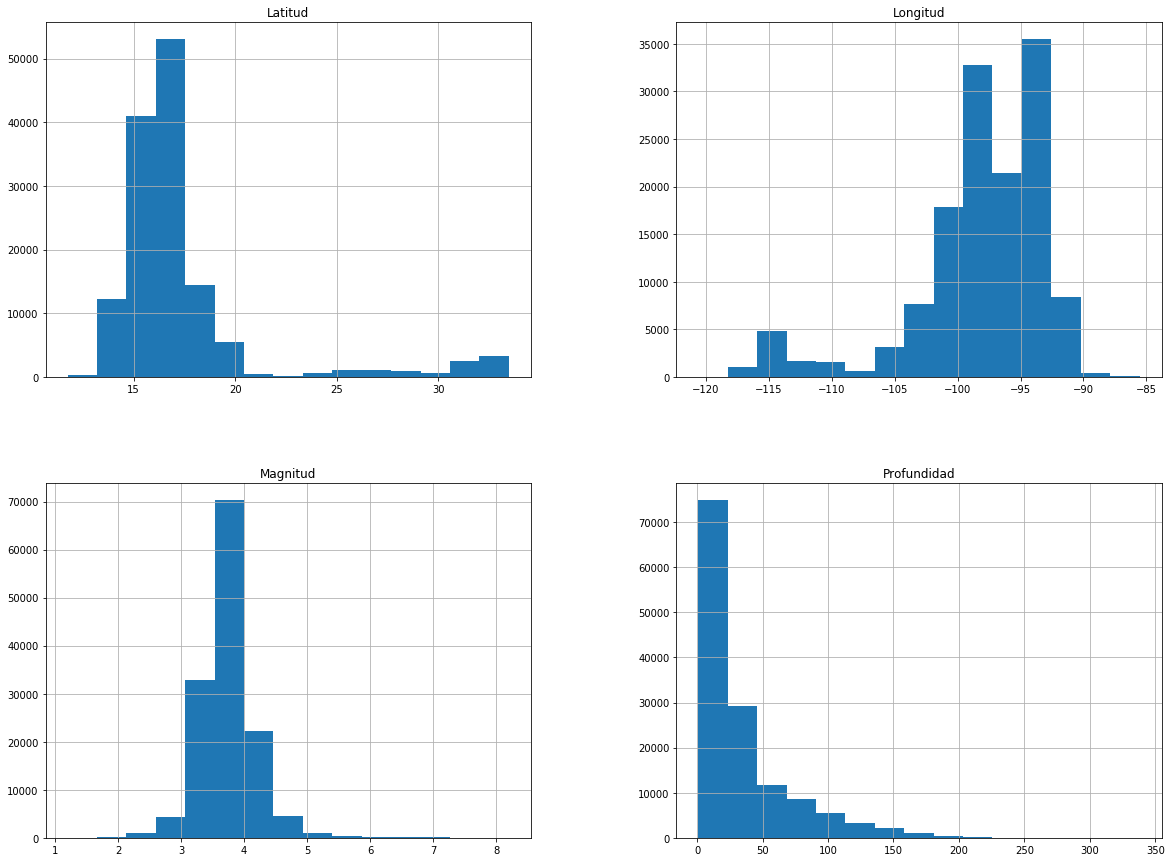

In [167]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=15, figsize=(20,15))
plt.show()

In [169]:
#df.plot(kind="scatter", x="Longitud", y="Latitud", alpha=0.4,s=df['Magnitud'].pow(1.5), label="Magnitud", figsize=(12,8),c="Magnitud", cmap=plt.get_cmap("seismic"), colorbar=True,sharex=False)
#plt.legend()

In [170]:
from pandas.plotting import scatter_matrix

attributes = ["Magnitud", "Profundidad", "Longitud", "Latitud"]
#scatter_matrix(df[attributes], figsize=(12, 8))

In [171]:
#df.set_index(['Fecha_Hora'],inplace=True)

In [172]:
#df[-136000:].plot(y=['Magnitud','Profundidad'],figsize=(20,14), alpha=0.5)
#df[df.Magnitud>6.5].plot(y='Magnitud',figsize=(20,14), alpha=0.3)

137020


<class 'numpy.ndarray'>


ValueError: Cannot have number of splits n_splits=3 greater than the number of samples: 0.